<div align="left">
# Capstone Project - Recommender System for Recipes
## Machine Learning Engineer Nanodegree
#### Claudia Cassidy, March 31, 2018
</div>
<hr>

## Project Overview

The goal of this project is to build a Recommender System for helping home cooks choose recipes. Unlike years ago, when people would look through recipe books and have index cards with a collection of up to 50 recipes, today there are hundreds of thousands of recipes freely available on the internet. With so many to choose from, it can be difficult to find just the right recipe that uses ingredients you have in your pantry, that takes just the right amount of time to prepare, and that will likely taste good to you and your family. This project aims to use machine learning to help home cooks answer the question: "What's for dinner?". <br>



Recommender Systems are commonly used in online shopping, for example where products are recommended for you based on products you've clicked on or searched for in the past. They are also used to recommend movies, as in Netflix where personalized recommendations are provided to each user. News services recommend articles to online readers.<br>

This report will look at Content-Based recommender systems in which properties of an item are examined so that other items which are similar to that item are recommended. In this project, we will examine recipe ingredients and categories to identify recipes that are similar to one another. We will also examine recipe ratings and number of reviews.

## Content Based Recommender System 

We will build a recipe association recommender, which although not personalized, will examine the properties of the recipe that a user is looking at. Based on the recipe's ingredients, categories and title, it will provide recipe recommendations.<br>

One way of providing these recommendations is to go through all the recipes and see 
what other ingredients have most frequently been part of the recipe along with the given ingredient in the same recipe. We can start by calculating what percentage of recipes with ingredient X (ingredient that the user is currently looking at) also has ingredient Y in the same recipe.<br>

We can count the number of recipes that have ingredient X and Y, our numerator, and
divide it by the number of recipes that have ingredient X. If, for example, at least 80% of recipes contain X and Y, then Y is a likely ingredient to add if you’re already using X. We will try to build a system that recommends recipes that are similar to a particular recipe and then list the top 10 closest matches.

### Analysis

AllRecipes.com is a community based website where people, mostly home cooks, submit their own recipes and have them published on the website. Most of the people who contribute recipes are not professional chefs.<br>

I was able to generate a dataset of over 8,100 recipes by scraping the web pages of AllRecipes.com.  An example of the script I wrote to scrape the recipes is in file "arSaladR.py". Recipes were scraped by categories as defined by AllRecipes.com. Using BeautifulSoup I scraped recipes in categories such as chicken, beef, salad, bread, pasta, vegetarian, cookies, beans, fish, and more. The data was written to csv files and then combined into a master spreadsheet.  

### Data Structure

Recipes on AllRecipes.com are structured according to Google's Recipe schema. Once scraped, the recipes were broken down into the following fields:<br>


<li>title: recipe name
<li>url: link to the original recipe on AllRecipes.com
<li>category: one category that this recipe falls in, as defined by AllRecipes.com
<li>prep time: how long it takes to prepare the ingredients before they are cooked
<li>cook time: how long it takes to cook
<li>total time: how long it takes to make this recipe: total of preparation time plus cooking time
<li>servings: number of servings this recipe makes
<li>rating: average overall rating for this recipe
<li>review_count: number of reviews this recipe has received
<li>categories: an array of food categories that this recipe falls in, as defined by AllRecipes.com
<li>author: the person who contributed the recipe
<li>ingredients: array of ingredients
<li>instructions: array of instructions for how to make the recipe
<li>fat: health information: amount of fat per serving
<li>calories: health information: amount of calories per serving
<li>carbohydrates: health information: amount of carbohydrates per serving
<li>protein: health information: amount of protein per serving
<li>cholesterol: health information: amount of cholesterol per serving
<li>sodium: health information: amount of sodium per serving
<li>reviews_text: the text of up to 6 reviews<br>
<br>
The fields which I selected from the dataset are title, categories, category and ingredients. I also experimented with rating and review_count. Here is a sample of the data.


In [1000]:
data.head(5)

,title,category,categories,ingred,rating,review_cnt,reviews_text,ingredSpaces,categories_clean,ingred_cat
0,'Anything Goes' Easy Black Beans,Beans and Peas,"['Side Dish', 'Beans and Peas']","blackbeans,chickenbroth,more,tomatopaste,groun...",3.50,6,"['Darin and I liked it...boys thought so so', ...",blackbeans chickenbroth more tomatopaste groun...,sidedish beansandpeas,blackbeans chickenbroth more tomatopaste groun...
1,'Calabacitas Guisada' (Stewed Mexican Zucchini),Tomatoes,"['Side Dish', 'Vegetables', 'Tomatoes']","vegetableoil,whiteonion,clovesgarlic,zucchini,...",4.60,83,['A simple and tasty dish! I also used olive o...,vegetableoil whiteonion clovesgarlic zucchini ...,sidedish vegetables tomatoes,vegetableoil whiteonion clovesgarlic zucchini ...
2,'Chinese Buffet' Green Beans,Green Beans,"['Side Dish', 'Vegetables', 'Green Beans']","oil,peanutsesame,clovesgarlic,greenbeans,white...",4.54,227,['**IMPORTANT NOTE** Thanks to everyone who ha...,oil peanutsesame clovesgarlic greenbeans white...,sidedish vegetables greenbeans,oil peanutsesame clovesgarlic greenbeans white...
3,'Meat's Too Expensive!' Vegetarian Burgers,Everyday Cooking,['Everyday Cooking'],"watercover,driedlentils,wheatgerm,onion,greenb...",4.25,3,"['Best tasting veggie burger I have made, ever...",watercover driedlentils wheatgerm onion greenb...,everydaycooking,watercover driedlentils wheatgerm onion greenb...
4,"""Couldn't Be Easier"" Three-Bean Salad",Three Bean Salad,"['Salad', 'Beans', 'Three Bean Salad']","greenbeans,limabeans,redbeans,redbellpepperstr...",4.00,3,['I thought this was good and it was even bett...,greenbeans limabeans redbeans redbellpepperstr...,salad beans threebeansalad,greenbeans limabeans redbeans redbellpepperstr...


In [790]:
#import needed packages
from gensim.models import doc2vec

import re
import pandas as pd
import numpy as np
import copy

# nltk processing
import nltk
from nltk.tag import pos_tag
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.classify import NaiveBayesClassifier

### Data Exploration


The master dataset was trimmed down to use the fields: title, category, categories, ingredients, rating and review_cnt. 

In [1002]:
data = dataMaster[['title','category','categories','ingred','rating','review_cnt','reviews_text']].copy()
data.head(5)

,title,category,categories,ingred,rating,review_cnt,reviews_text
0,'Anything Goes' Easy Black Beans,Beans and Peas,"['Side Dish', 'Beans and Peas']","['2 (15 ounce) cans black beans, rinsed and dr...",3.50,6,"['Darin and I liked it...boys thought so so', ..."
1,'Calabacitas Guisada' (Stewed Mexican Zucchini),Tomatoes,"['Side Dish', 'Vegetables', 'Tomatoes']","['1 tablespoon vegetable oil', '1/2 small whit...",4.60,83,['A simple and tasty dish! I also used olive o...
2,'Chinese Buffet' Green Beans,Green Beans,"['Side Dish', 'Vegetables', 'Green Beans']","['1 tablespoon oil, peanut or sesame', '2 clov...",4.54,227,['**IMPORTANT NOTE** Thanks to everyone who ha...
3,'Meat's Too Expensive!' Vegetarian Burgers,Everyday Cooking,['Everyday Cooking'],"['water to cover', '1 cup dried lentils', '1/2...",4.25,3,"['Best tasting veggie burger I have made, ever..."
4,"""Couldn't Be Easier"" Three-Bean Salad",Three Bean Salad,"['Salad', 'Beans', 'Three Bean Salad']","['1 cup frozen cut green beans', '1 cup frozen...",4.00,3,['I thought this was good and it was even bett...


### Data Cleaning

When looking at the data, it became clear that the most relevant words are the names of food items and categories.  Other words, characters and numbers would not be useful for this exercise. for example, we need to get rid of stop words (common words like "as", "the") and measurement words (for example 1/2 tablespoon) which don't say anything about the food. <br>
For example, "ground beef" becomes "groundbeef", "beef bouillon cube" becomes "beefbouilloncube".

The first step was to define a food vocabulary. Non-food words, such as measurements, punctuation, and descriptions about the state of a food item should be removed from the ingredients. Shown here is a function to remove non-food words from the ingredient words: "clean_data_ingred()".

In [977]:
### removed measurements, descriptive words and anything that's not an ingredient
def clean_data_ingred(ds):
    arr = ['tablespoons','tablespoon','teaspoons','teaspoon','cups','cup',
           'ounces','ounce','pounds','pound','pinches','pinch','tastes',
           'taste','dashes','dash','/',' or ',' as ',' and ', '-','[',']',
           '(',')','.','slices','sliced','slice', '0','1','2','3',
           '4','5','6','7','8','9','juiced','diced','minced','chopped',
           ' cans',' canned ', ' can ', ' inches ', ' inch ','package', 
           'finely', 'crushed', 'shredded', 'divided', ' melted ', ' jar ',
           'thawed', ' cut ', ' to ', ' thick ', ' across ',' bones ', 
           'optional', ' split ', ' torn ', ' into ', ' strips ', 'peeled',
           ' pieces', ' lightly ', ' beaten ','ground black', 'scrubbed', 
           'jars', 'beaten','pitted','halved', 'thinly','as needed','large',
           'medium','small','roughly','fluid','drained','crumbled','rinsed',
           'cubed','seeded','fresh',' plus ', ' more ', 'deboned', 
           'prepared', 'cubes', 'uncooked', 'cooked', 'grated', ' lean ',
           'into chunks', 'coarsely','seeded','freshly',' freshly', 'fresh',
           ' with ',  'liquid','quartered','lengthwise','small',' into ',
           ' bite ', ' sized ', ' ly ', ' ed ', ' s ','cut into', ' up ', 
           'trimmed','frozen','chunks','segments','softened',' cut ', 
           ' stewed','pieces','broken',' cored',' rings',' torn ','seasoned',
           ' into ','eighths','quarters','halves','thirds',' thick ', 
           'chilled',  ' more',' ',"'"]

    ### merge terms that have multiple words, for example 'ground beef' becomes 'groundbeef'
    for item in arr:
        ds = ds.str.replace(item,'')
    ds = ds.str.replace(',,',',')
    return ds

In [978]:
### Remove measurements and anything else that is not a food ingredient from the ingredients data
data['ingred'] = clean_data_ingred(data['ingred'])



## Analysis

The next step was to compute TF-IDF scores for the remaining words. Ingredient terms can consist of more than one word. In order to make sure that the model does not treat an ingredient like "ground beef" as two separate words, for example "ground" and "beef", ingredients with multiple words were combined into a single word. For example, "ground beef" becomes "groundbeef" and "beef bouillon cube" becomes "beefbouilloncube". Each term was then separated by a space.

In [979]:
### separate each term with a space
def create_soup(ds):
    ds = ds.str.replace(',',' ')
    return ds

In [981]:
### Separate each ingredient with a space
data['ingredSpaces'] = create_soup(data['ingred'])


### Adding Categories Feature
As we did with the ingredients data, we will remove characters from the Categories data which are not letters, for example, punctuation marks. Multiple word terms will be combined into single words, for example: "side dish" becomes "sidedish".

In [982]:
def clean_categories(ds):
    ds = ds.str.replace(' ','')
    ds = ds.str.lower()
    ds = ds.str.replace('[','')
    ds = ds.str.replace(']','')
    ds = ds.str.replace("''",' ')
    ds = ds.str.replace(',',' ')
    ds = ds.str.replace("'","")
    return ds

In [983]:
data['categories_clean'] = clean_categories(data['categories'])


In [1001]:
# Merge ingredients and categories into one column
data['ingred_cat'] = data['ingredSpaces'] + ' ' + data['categories_clean'] 
data['ingred_cat'].head(5)

0    blackbeans chickenbroth more tomatopaste groun...
1    vegetableoil whiteonion clovesgarlic zucchini ...
2    oil peanutsesame clovesgarlic greenbeans white...
3    watercover driedlentils wheatgerm onion greenb...
4    greenbeans limabeans redbeans redbellpepperstr...
Name: ingred_cat, dtype: object

### Ingredient plus Categories Word Cloud 
Shown below is a word cloud which illustrates how frequently some ingredients occur among all the recipes in our dataset.

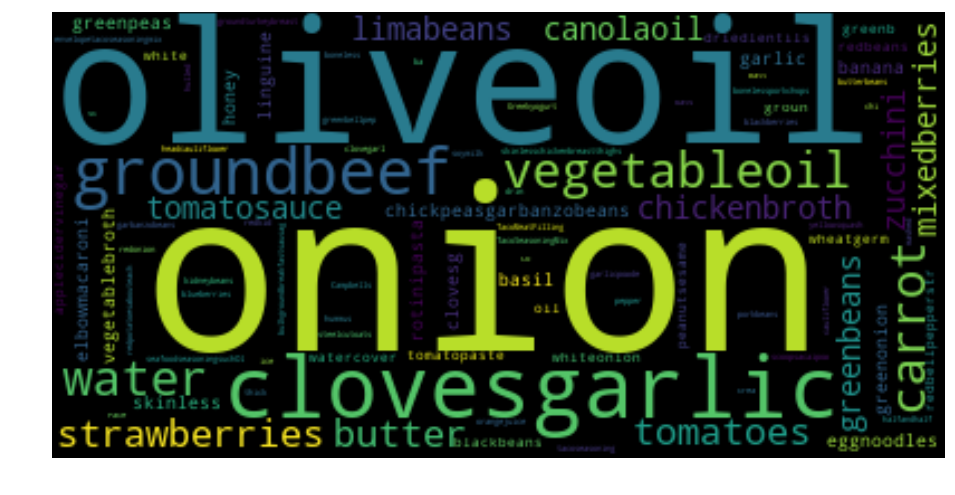

In [985]:
from wordcloud import WordCloud

#wordcloud = WordCloud().generate(str(data['ingredSpaces']))
wordcloud = WordCloud().generate(str(data['ingred_cat']))


import matplotlib.pyplot as plt

                                 
plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()



The larger the font size, the more frequently the ingredient occurs in our dataset of recipes. The largest words, such as onion, oliveoil, butter, chickenbroth, clovesgarlic and vegetableoil can even be considered as what chef's call "staples", i.e. ingredients that are so frequently used that it can be assumed that every cook is well stocked with these items in their kitchens. For our purposes, these "high frequency" ingredients are less important because they are so common.

### Compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each recipe
Calculating TF-IDF indecates the importance of each food term to the recipe it belongs to. How many times a word appears in the recipe it belongs to is the TF (term frequency). The higher the TF value, the more important the term is. However, if the term appears in all recipes, then it is not really important for a particular recipe to be identified. For example, most recipes contain "salt". If every recipe contains salt then the term "salt" would not be helpful to identify each recipe. So we want to have a weighting system that decreases the importance of a term like salt when the number of the recipes it appears in increases.<br>
TF-IDF is a weighting mechanism that calculates the importance of each term to each recipe by increasing the importance based on the term frequency while decreasing the importance based on the recipe frequency.<br>

In [801]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(data['ingred_cat'].values.astype('U'))

#Output the shape of tfidf_matrix
tfidf_matrix.shape


(10542, 7876)

In [802]:
print("Now the recipes are characterized by the ingredients with the highest TF-IDF scores.") 
print(tfidf_matrix.shape[1], "different terms were used to describe", tfidf_matrix.shape[0], "recipes in the dataset.")

Now the recipes are characterized by the ingredients with the highest TF-IDF scores.
7876 different terms were used to describe 10542 recipes in the dataset.


In [803]:
tfidf_matrix

<10542x7876 sparse matrix of type '<class 'numpy.float64'>'
	with 132313 stored elements in Compressed Sparse Row format>

#### Calculating Similarity

Using the TFIDF matrix we can compute a similarity score, the cosine distance between the high TF-IDF words as a vector. We will use a cosine similarity to calculate a number that denotes the similarity between two recipes.

$$cosine(x,y0) = x.y^T / ||x||.||y||$$


To compute the cosine distance we think of the sets of high TF-IDF words as a vector, with one component for each possible word. The vector has 1 if the word is in the set and 0 if not. Almost all components are 0 in both, and 0’s do not impact the value of the dot product. The dot product is the size of the intersection of the two sets of ingredient words, and the lengths of the vectors are the square roots of the numbers of words in each set. That lets us compute the cosine of the angle between the vectors as the dot product divided by the product of the vector lengths.


In [804]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

Next, we need a function that takes in a recipe title as an input and outputs a list of up to the 10 most similar recipes. To do this, we make a reverse mapping of recipe titles and dataframe indices. This gives us a way to identify the index of a recipe, given its title.

In [986]:
#Construct a reverse map of indices and recipe titles
indices = pd.Series(data.index, index=data['ingred_cat'])


#### CountVectorizer instead of TF-IDF

We will also try using the CountVectorizer() instead of TF-IDF for this attempt. Using CountVectorizer will not down-weight the presence of an ingredient if it appears in relatively more recipes. We will use a CountVectorizer with a pairwise cosine similarity calculation and then compare the results of TF-IDF vs CountVectorizer.

In [807]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(data['ingred_cat'])


In [808]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [809]:
count_matrix

<10542x7876 sparse matrix of type '<class 'numpy.int64'>'
	with 132313 stored elements in Compressed Sparse Row format>

In [810]:
# Function that takes in ingredient as input and outputs most similar ingredients
def get_recommendations(title, cosine_sim=cosine_sim):

    # Get the index of the recipe title that matches the title
    row = data.loc[data['title'] == title].index[0]
    idx = indices[row]

    # Get the pairwise similarity scores of all titles with that title
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on the similarity scores    
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:16]
 
    # Get the recipe indices
    recipe_indices = [i[0] for i in sim_scores]
    
    # Return the top 10-15 most similar recipes
    return data['title'].iloc[recipe_indices].drop_duplicates()


#### Results
Here are some examples of recipe recommendations. We call the "get_recommendations()" function and pass in the index of the recipe and specify cosine similarity. The function returns a list of up to 10 closest recipes.

##### Example: Baked Slow Cooker Chicken, TF-IDF

In [1003]:
get_recommendations('Baked Slow Cooker Chicken', cosine_sim)  


866                                Beer Butt Chicken
432                            Bacon Roasted Chicken
6714                    Simple Whole Roasted Chicken
5381                          Oven Fried Chicken III
3975                          Honey Baked Chicken II
7134                          Spicy Lemon Pork Saute
3362                    Get a Husband Brunswick Stew
8099           Vegetarian Alternative to Ground Beef
10427    Homemade Chicken Cacciatore, Sicilian-Style
6763                       Slow Cooked Pork Barbeque
10177                        Chicken Chile Spaghetti
Name: title, dtype: object

##### Example: Baked Slow Cooker Chicken, CountVectorizer

In [812]:
get_recommendations('Baked Slow Cooker Chicken', cosine_sim2) 

866                         Beer Butt Chicken
432                     Bacon Roasted Chicken
3923      High Temperature Eye-of-Round Roast
6763                Slow Cooked Pork Barbeque
6410               Sarge's EZ Pulled Pork BBQ
8099    Vegetarian Alternative to Ground Beef
1394                              Bum's Lunch
6773                     Slow Cooker Barbeque
1460                             Cabin Dinner
1919                    Chicken Fried Steak I
3715                  Ground Beef and Cabbage
4296                        Juicy Butt Steaks
Name: title, dtype: object

##### Example: Steamed Asian Sesame Veggies, TF-IDF

In [813]:
get_recommendations('Steamed Asian Sesame Veggies', cosine_sim) 

7258                            Steamed Broccoli
1283         Broccoli in Roast Chicken Drippings
1298           Broccoli With Lemon Almond Butter
7637                              Tangy Broccoli
6968              Snow Peas with Water Chestnuts
6202                      Roasted Broccoli Salad
6568                             Sesame Broccoli
4235    Japanese Spinach with Sweet Sesame Seeds
7286                          Stir-Fried Pumpkin
6967                          Snow Peas Oriental
1287                          Broccoli Polonaise
1277         Broccoli Cheese Casserole with Rice
1942                            Chicken Stir-Fry
7291         Stir-Fry Broccoli With Orange Sauce
6569                Sesame Cabbage and Mushrooms
Name: title, dtype: object

##### Example: Steamed Asian Sesame Veggies, CountVectorizer

In [814]:
get_recommendations('Steamed Asian Sesame Veggies', cosine_sim2) 

1283           Broccoli in Roast Chicken Drippings
7637                                Tangy Broccoli
7258                              Steamed Broccoli
1277           Broccoli Cheese Casserole with Rice
6568                               Sesame Broccoli
3609    Grilled Broccoli--My Kids Beg for Broccoli
1298             Broccoli With Lemon Almond Butter
6202                        Roasted Broccoli Salad
1287                            Broccoli Polonaise
3337                      Garlic-Sauteed Asparagus
7250           Stacey's Fabulous Broccoli Fritters
7291           Stir-Fry Broccoli With Orange Sauce
2888                Easy Lemon and Garlic Broccoli
7100                Spicy Bok Choy in Garlic Sauce
1754        Cheesy Cauliflower and Broccoli Gratin
Name: title, dtype: object

##### Example: Urban Legend Chocolate Chip Cookies, TF-IDF

In [815]:
get_recommendations('Urban Legend Chocolate Chip Cookies', cosine_sim)

2353                               Cowboy Cookies III
5271                 Oatmeal Chocolate  Coconut Chewy
5200                Never Fail Chocolate Chip Cookies
3365                      Giant Chocolate Chip Cookie
930                       Best Chocolate Chip Cookies
6337                                         Rugelach
167                     Anna's Chocolate Chip Cookies
2352                       Cowboy Cookie Mix in a Jar
5272                 Oatmeal Chocolate Chip Cookies I
5372                Outrageous Chocolate Chip Cookies
355         Award Winning Soft Chocolate Chip Cookies
2056               Chocolate Chocolate Chip Cookies I
1169                         Bobbie's Oatmeal Cookies
7981    Ultimate High Altitude Chocolate Chip Cookies
2057              Chocolate Chocolate Chip Cookies II
Name: title, dtype: object

##### Example: Urban Legend Chocolate Chip Cookies, CountVectorizer

In [816]:
get_recommendations('Urban Legend Chocolate Chip Cookies', cosine_sim2) 

2353                                   Cowboy Cookies III
3365                          Giant Chocolate Chip Cookie
5200                    Never Fail Chocolate Chip Cookies
5271                     Oatmeal Chocolate  Coconut Chewy
930                           Best Chocolate Chip Cookies
167                         Anna's Chocolate Chip Cookies
355             Award Winning Soft Chocolate Chip Cookies
2056                   Chocolate Chocolate Chip Cookies I
1169                             Bobbie's Oatmeal Cookies
39      Absolutely Sinful Chocolate Chocolate Chip Coo...
1860                 Chewy Chocolate Chip Oatmeal Cookies
3054                            Excellent Oatmeal Cookies
5372                    Outrageous Chocolate Chip Cookies
1861                            Chewy Chocolate Cookies I
2057                  Chocolate Chocolate Chip Cookies II
Name: title, dtype: object

##### Example: Easy Lasagna I, TF-IDF

In [817]:
get_recommendations('Easy Lasagna I', cosine_sim)

9751                            Easy Lasagna I
2885                           Easy Lasagna II
10164                 Easy Four Cheese Lasagna
9726                                 Manicotti
6847                       Slow Cooker Lasagna
10166                Baked Spaghetti Casserole
4598                           Linda's Lasagna
9755                  Lasagna Alfredo Roll Ups
10138                           Cheese Lasagna
9925     Easy Spinach Lasagna with White Sauce
2886                          Easy Lasagna III
Name: title, dtype: object

##### Example: Easy Lasagna I, CountVectorizer

In [819]:
get_recommendations('Easy Lasagna I', cosine_sim2)

9751                Easy Lasagna I
2885               Easy Lasagna II
10164     Easy Four Cheese Lasagna
4470               Lazy Lasagna II
4815         Meat Filled Manicotti
10166    Baked Spaghetti Casserole
6847           Slow Cooker Lasagna
9670      Hearty Vegetable Lasagna
9726                     Manicotti
10464         Italian Veggie Rolls
10138               Cheese Lasagna
Name: title, dtype: object

##### Example: "The Best Post Workout Shake", TF-IDF

In [820]:
get_recommendations('The Best Post Workout Shake', cosine_sim) 

2642    Dairy-Free Chocolate Peanut Banana Smoothie
7448           Superfood Chocolate Pudding Smoothie
5553              Peanut Butter Strawberry Smoothie
630           Banana Chocolate Almond Milk Smoothie
3855             Healthy Cocoa, Banana, PB Smoothie
908                                 Berry Delicious
29                    A Very Intense Fruit Smoothie
2413                             Cranberry Smoothie
4320            Kale and Berries Breakfast Smoothie
3158                             Flax Seed Smoothie
47                 Acai Rainbow Smoothie Bowl for 2
6745                       Skinny Almond Milk Shake
3578                                 Green Smoothie
8162                        Very Berry Tea Smoothie
648                   Banana Peanut Butter Smoothie
Name: title, dtype: object

##### Example: "The Best Post Workout Shake", CountVectorizer

In [821]:
get_recommendations('The Best Post Workout Shake', cosine_sim2) 

2642     Dairy-Free Chocolate Peanut Banana Smoothie
7448            Superfood Chocolate Pudding Smoothie
630            Banana Chocolate Almond Milk Smoothie
908                                  Berry Delicious
3158                              Flax Seed Smoothie
3855              Healthy Cocoa, Banana, PB Smoothie
5553               Peanut Butter Strawberry Smoothie
5855                         Pumpkin Banana Smoothie
6745                        Skinny Almond Milk Shake
29                     A Very Intense Fruit Smoothie
642                       Banana Mocha Protein Shake
2047    Chocolate Banana Peanut Butter Protein Shake
2413                              Cranberry Smoothie
3578                                  Green Smoothie
3900                     Heavenly Blueberry Smoothie
Name: title, dtype: object

#### Results:
Both TF-IDF and CountVectorizer produced reasonable recipe recommendations based on the submitted recipe title. Many of the first few recipes returned were the same, but there were variations after about the fourth recipe. Overall, while both produced reasonable results, I found that the TF-IDF matrix returned recipes which were closer to the recipe title submitted. For example, "Steamed Asian Vegetables" results using the TF-IDF matrix returned on the mark recipes like "Stir-Fry Broccoli With Orange Sauce", while the CountVectorizer matrix, we see somewhat off the mark recipes like "Cheesy Cauliflower and Broccoli Gratin".


## 2 - Recommender System Considering Ratings and Number of Reviews

Since ratings can be different based on the number of reviews, for example should a recipe with only 3 ratings, where the average rating is 5.0, be evaluated as having a truly higher rating than a recipe with 500 ratings, where the average rating is about 4.0?<br>

In order to be fair, we are going to use a weighted ratings.<br>

v: number of reviews for the recipe<br>

m: minimum number of votes required to be listed<br>

R: average rating of the recipe<br>

C: mean vote across all recipes<br>

We will use 90th percentile as the cutoff in terms of number of reviews.<br>


In [844]:
# read in fields title, ingredients and categories
dataR = data 


In [845]:
C = dataR['rating'].mean()
print("average rating of all recipes: ",C)

average rating of all recipes:  4.166075697211155


In [987]:
m = dataR['review_cnt'].quantile(0.9)
print("90th percentile for number of reviews, i.e. the top 10th percentile recipes that have been reviewed the most: ",m)

90th percentile for number of reviews, i.e. the top 10th percentile recipes that have been reviewed the most:  474.0


In [848]:
# Filter out all qualified recipes into a new DataFrame
q_data = dataR.copy().loc[dataR['review_cnt'] >= m]
q_data.shape

(1058, 10)

There are 872 recipes which qualify to be in this list. Now, we need to calculate our metric for each qualified recipe. To do this, we will define a function, weighted_rating() and define a new feature score, of which we'll calculate the value by applying this function to our dataframe of qualified recipes:

In [851]:
# Function that computes the weighted rating of each recipe
def weighted_rating(x, m=m, C=C):
    v = x['review_cnt']
    R = x['rating']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)


In [852]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_data['score'] = q_data.apply(weighted_rating, axis=1)

In [853]:
#Sort recipes based on score calculated above
q_data = q_data.sort_values('score', ascending=False)
q_data2 = q_data[['title','category', 'review_cnt', 'rating', 'score']].drop_duplicates('title',keep=False)


#### Top 20 Recipes by Average Rating and Number of Reviews

In [854]:
#Print the top 20 recipes
q_data2.head(20)

,title,category,review_cnt,rating,score
3163,Fluffy Pancakes,Pancakes,9933,4.82,4.790216
1932,Chicken Pot Pie IX,Chicken Breasts,8068,4.81,4.774268
636,Banana Crumb Muffins,Banana Muffins,9774,4.80,4.770679
2760,Downeast Maine Pumpkin Bread,Breakfast Bread,6877,4.81,4.768479
4229,Janet's Rich Banana Bread,Banana Bread,4944,4.82,4.762791
2185,Clone of a Cinnabon,Yeast Bread,5629,4.81,4.759989
7618,Taco Seasoning I,Mexican,4348,4.82,4.755720
3494,Grandmother's Buttermilk Cornbread,Cornbread,4906,4.81,4.753268
1172,Boilermaker Tailgate Chili,Beef Chili,4663,4.81,4.750584
3731,Guacamole,Guacamole,4222,4.81,4.745004


Our dataset does not include individual user ratings. Shown above we can see the highest rated recipes overall as determined by the average rating and number of reviews. While this may represent the overall average ratings, it is not personalized to individual preferences. We would need individual user preference data to better recommend recipes for individuals.  For example, if someone is following a low-carb diet, then almost none of these highest rated recipes would be relevant to that person.  

## 3 - Recommender System with Word2Vec

One of the key ideas in Natural Language Processing (NLP) is converting words into numeric vectors. The vectors are then fed into machine learning models in order to perform predictions.
One way of converting words into numeric vectors is to use a "one-hot" method whick converts one element of the vector to a 1 value with the rest of the elements being 0. So a sentence like "the cat sat on the mat" would be converted to a 6x5 matrix that looks like:

the 1 0 0 0 0<br>
cat 0 1 0 0 0<br>
sat 0 0 1 0 0<br>
on  0 0 0 1 0<br>
the 1 0 0 0 0<br>
mat 0 0 0 0 1<br>

As the dataset grows larger, the one hot encoding method becomes inefficient. It also does not show the similarity among words. <br>

The first component to the Word2Vec methodology is word embedding while maintaining context. One approach to doing this is the Skip-Gram method in which we take an input word and then try to estimate the probability of other words appearing close to that word. The second method is Continuous Bag of Words (CBOW), which does the opposite.  It takes some context words as input and then tries to find a single word that has the highest probability of fitting that context.[1]<br>



In [834]:
from string import punctuation
from os import listdir
from numpy import array
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.embeddings import Embedding
from keras.layers import Input, Reshape, merge
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing import sequence
import keras.models as kmodels
import keras.layers as klayers
import keras.backend as K
import keras
from collections import Counter
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import gensim 
import urllib
import collections
import os
import zipfile
import tensorflow as tf
from __future__ import absolute_import, division, print_function
import codecs
import glob
import multiprocessing
import pprint
import re
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import matplotlib.pyplot as plt
import pandas as pd


Word2Vec is a group of related models that are used to produce word embeddings. These models are shallow, two layer neural networks that are trained to reconstruct linguistic contexts of words. Word2Vec produces a vector space of hundreds of dimensions, with each unique word assigned a corresponding vector in the space. Word vectors are positioned in the vector space such that words that share common contexts are located near to one another in the space.[2]

Word2Vec learns the context of a word by looking at the words which commonly occur around the target word. Words which have similar contexts share meaning under Word2Vec, and their reduced vector representations will be similar.  In the skip-gram model version of Word2Vec the goal is to take a target word and predict the surrounding context words. We will attempt to apply this technique to recipe ingredients, learning ingredients that commonly occur together. <br>

We will supply our input target words as one-hot vectors to the neural network.  Then, via a hidden layer, we will train the neural network to increase the probability of valid context words, while decreasing the probability of invalid context words.<br>

There are two variants of the Word2Vec paradigm: skip-gram and CBOW. The skip-gram variant takes a target word and tries to predict the surrounding context words. The CBOW (continuous bag of words) variant takes a set of context words and tries to predict a target word.  In this case, we will be considering the skip-gram variant.

We also need a way of ensuring that as the network trains, words which are similar end up having similar embedding vectors.  We want to ensure that the trained network will always output a 1 when it is supplied words which are in the same context, but 0 when it is supplied words which are never in the same context. Therefore, we need a vector similarity score supplied to the output sigmoid layer – with similar vectors outputting a high score and un-similar vectors outputting a low score. As we did previously, we will use the cosine similarity score.<br>


In [855]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/claudiacassidy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/claudiacassidy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [856]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')


In [910]:
dataR = data[['title','category','categories','ingred','ingred_cat','rating','review_cnt','reviews_text']].copy()


##### Convert the ingredients and categories into a list of words

In [920]:
# Convert ingred_cat into a list of words
# Remove unnnecessary characters, split into words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

##### Create tokens for each word

In [921]:
sentences = []
for raw_sentence in dataR['ingred_cat']:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [922]:

token_count = sum([len(words) for words in sentences])
print("The recipes corpus contains {0:,} tokens".format(token_count))

The recipes corpus contains 138,366 tokens


The quality of word embedding increases with higher dimensionality, but after reaching some point, marginal gain will diminish and it can become more computationally expensive to train. Typically, the dimensionality of the vectors is set to be between 100 and 1,000.  We will set the dimensionality to 300.[2] 

In [923]:
#vectors help with distance, similarity, ranking

num_features = 300

#minimum word count threshold
min_word_count = 3

num_workers = multiprocessing.cpu_count()

#context window length
context_size = 7

#downsample setting for frequent words
#0 - 1e-5 is good for this
downsampling = 1e-3

#random number generator
#deterministic, good for debugging
seed = 1


### Training Word2vec

In [924]:
model = w2v.Word2Vec(sg=1,
                     seed=seed,
                     workers=num_workers,
                     size=num_features,
                     min_count=min_word_count,
                     window=context_size,
                     sample=downsampling)

In [925]:
# loads corpus into memory
model.build_vocab(sentences, update=False)


In [926]:
model.train(sentences,total_examples=model.corpus_count,epochs=10)

(986603, 1383660)

In [927]:
# save the trained model to file model.w2v
if not os.path.exists("trained"):
    os.makedirs("trained")

model.save(os.path.join("trained","model.w2v"))

In [928]:
# to load the model from file
ingred_cat_model = w2v.Word2Vec.load(os.path.join("trained", "model.w2v"))

##### We will use TSNE to visualize the high dimensional data.<br>
t-distributed stochastic neighbor embedding is a nonlinear dimensionality reduction technique that is useful for embedding high dimensional data into a space of two or three dimensions, which can then be ivuslized in a scatter plot. Similar objects are modeled by nearby points and dissimilar objects are modeled by distant points.[3]

In [929]:
# TSNE is a tool to visualize high dimensional data. 
tsne = sklearn.manifold.TSNE(n_components=2,random_state=0)

In [930]:
all_word_vectors_matrix = ingred_cat_model.wv.syn0

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [931]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [932]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[ingred_cat_model.wv.vocab[word].index])
            for word in ingred_cat_model.wv.vocab
        ]
    ],
    columns=["word","x","y"]
)

In [936]:
points.head(5)

,word,x,y
0,blackbeans,7.219711,-39.946884
1,chickenbroth,34.706032,-10.511361
2,more,-44.372906,-9.446028
3,tomatopaste,24.073683,-32.281361
4,groundcumin,11.810753,-36.304474


Shown above is a sample of ingredients and there x,y coordinates.

In [937]:
# Reset index of the main DataFrame and construct reverse mapping as before
dataR = dataR.reset_index()
indices = pd.Series(dataR.index, index=dataR['ingred_cat'])

In [938]:
import seaborn as sns
sns.set_context("poster")

Here is a scatter plot of our ingredient words.

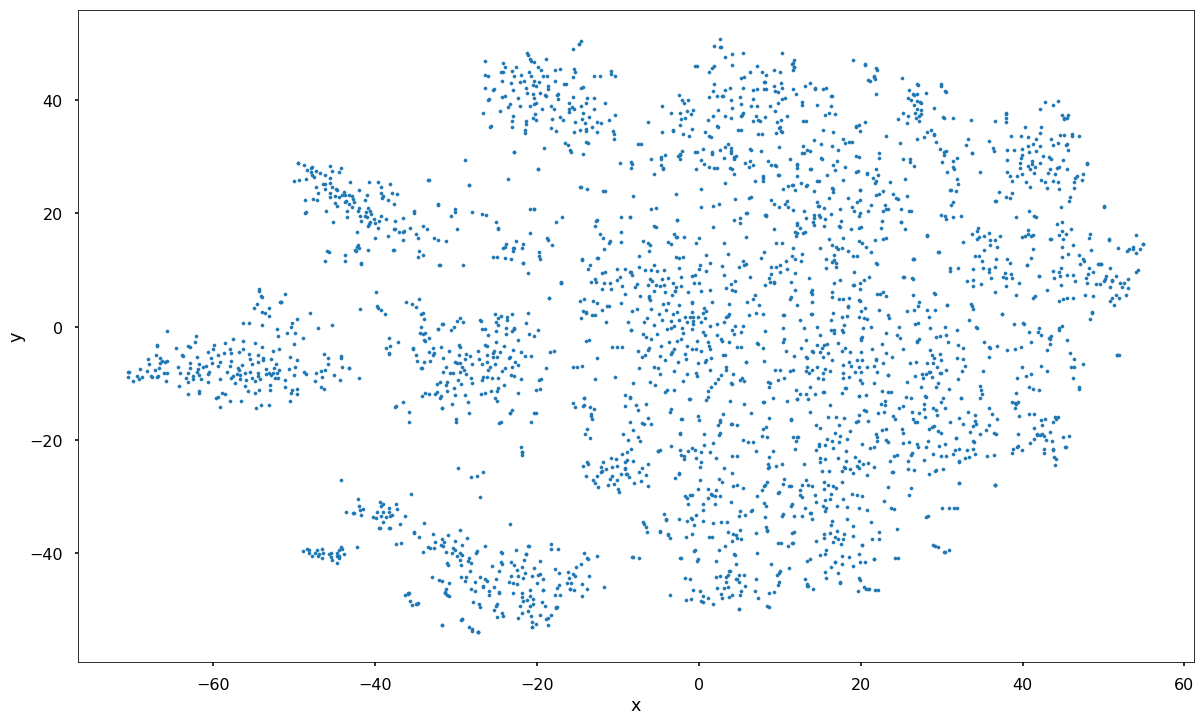

In [939]:
#plot the word vectors
points.plot.scatter("x","y", s=10, figsize=(20,12))

Shown below is a zoomed in region of the scatter plot. It shows that similar items are located near each other.  For example, it shows how potato rounds are near hash brown potatoes.

In [945]:
#zoom in

def plot_region(x_bounds,y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10,8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
        
    

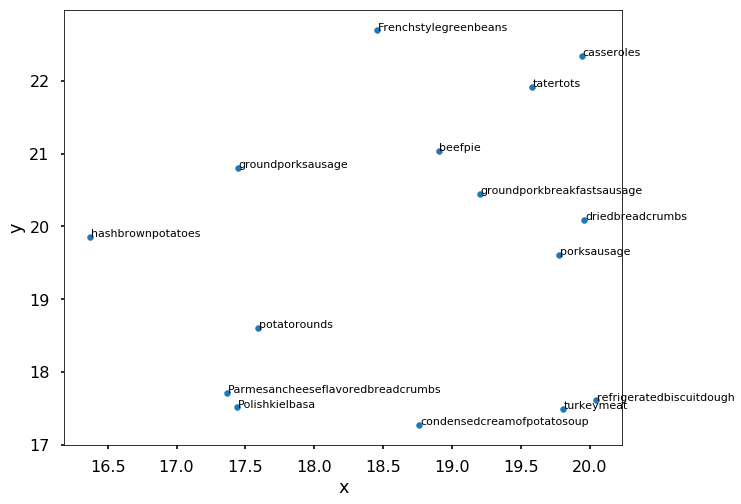

In [946]:
plot_region(x_bounds=(16.1,20.8), y_bounds=(16.1,23.1))

### Finding items which are most similar to a given ingredient<br>

We can now submit an ingredient and get a prediction of which other ingredients are most related to the given ingredient. Shown below are several examples.

##### Ingredients which are most related to ground beef:

In [947]:

ingred_cat_model.wv.most_similar("groundbeef")

[('extraleangroundbeef', 0.7729963064193726),
 ('condensedtomatosoup', 0.7189244627952576),
 ('groundsausage', 0.7185359001159668),
 ('groundbeefchuck', 0.7073467969894409),
 ('mushroomstems', 0.7041727304458618),
 ('stuffedmaindishes', 0.698028028011322),
 ('meatloaf', 0.6942072510719299),
 ('dryzitipasta', 0.6904700994491577),
 ('tomatojuice', 0.6893602609634399),
 ('beefmeatloaf', 0.6823640465736389)]

##### Ingredients which are most related to tomatoes:

In [948]:
ingred_cat_model.wv.most_similar("tomatoes")

[('Italianstyletomatoes', 0.7856447696685791),
 ('cantomatoes', 0.7755200862884521),
 ('wholetomatoes', 0.7695765495300293),
 ('wholetomatoesjuice', 0.7579359412193298),
 ('driedredpepperflakes', 0.7557766437530518),
 ('lightredkidneybeans', 0.751220703125),
 ('redbeans', 0.7505274415016174),
 ('hotItaliansausage', 0.7492036819458008),
 ('hotsalsa', 0.7461246252059937),
 ('Mexicanstyletomatoes', 0.745964765548706)]

##### Ingredients which are most related to almond milk:

In [949]:
ingred_cat_model.wv.most_similar("almondmilk")

[('flaxseedmeal', 0.9310940504074097),
 ('flaxseeds', 0.9304770231246948),
 ('hempseeds', 0.9259158372879028),
 ('almondbutter', 0.9244171380996704),
 ('soymilk', 0.9235554933547974),
 ('groundflaxseed', 0.9172952771186829),
 ('scoopvanillaproteinpowder', 0.9127264022827148),
 ('spirulinapowder', 0.9112852811813354),
 ('chiaseeds', 0.9052334427833557),
 ('vanillaproteinpowder', 0.9029464721679688)]

##### Ingredients which are most related to cabbage:

In [950]:
ingred_cat_model.wv.most_similar("cabbage")

[('headcabbage', 0.8200525045394897),
 ('headredcabbage', 0.7687333822250366),
 ('carawayseeds', 0.7406169176101685),
 ('bunchescollardgreens', 0.7396249771118164),
 ('containerschickenbroth', 0.7260845899581909),
 ('quartwater', 0.7059028148651123),
 ('bunchesturnipgreens', 0.7029920220375061),
 ('quartswater', 0.7026071548461914),
 ('intomatchsticksize', 0.7002438306808472),
 ('bunchesmustardgreens', 0.6979999542236328)]

##### Ingredients which are most related to beef:

In [951]:
ingred_cat_model.wv.most_similar("beef")

[('steaks', 0.8334396481513977),
 ('sirloinsteak', 0.7732095718383789),
 ('rib', 0.7576472759246826),
 ('eyesteak', 0.7522614002227783),
 ('filetmignon', 0.7265390157699585),
 ('roundsteak', 0.7246712446212769),
 ('cubesteaks', 0.7171943187713623),
 ('beefconsomme', 0.7168818116188049),
 ('ribeyesteaks', 0.7155680656433105),
 ('beefstroganoff', 0.7098640203475952)]

### Showing analogies: ingredient A is to ingredient B as ? is to ingredient C

We can use the cosine similarity to calculate the similarities among ingredients. 

In [952]:
# using cosine similarity 
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = ingred_cat_model.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    
    print(start1, "is related to", end1, "as", start2, "is related to", end2)
    return start2
    

We will pass in three parameters to the nearest_similarity_cosmul function: start1: ingredient A, end1: ingredient B, end2: ingredient C

In [957]:
nearest_similarity_cosmul("salt","beef","chicken")

salt is related to beef as margarinebutter is related to chicken


'margarinebutter'

In [961]:
nearest_similarity_cosmul("chickenstock","soup","cookies")

chickenstock is related to soup as flakedcoconut is related to cookies


'flakedcoconut'

In [968]:
nearest_similarity_cosmul("onion","pork", "groundbeef")

onion is related to pork as hotItaliansausage is related to groundbeef


'hotItaliansausage'

The analogies tested above don't quite make sense but are not too far fetched.

#### Looking up recipes that contain multiple ingredients

One of the objectives of this project is to be able to quickly find recipes given ingredients that the home cook has on hand.  We will now write a function that returns recipes which contain multiple ingredients and sort them by average rating.

In [969]:
# Lookup recipes that contain ingredients
def find_recipes_with_ingredient(ingred,ingred2):
    match = dataR[dataR['ingred_cat'].str.contains(ingred)] 
    match2 = match[match['ingred_cat'].str.contains(ingred2)]
    match3 = match2.sort_values('rating', ascending=False)
    
    return match3

##### Recipes which contain both spinach and chicken, sorted by highest rating

In [995]:

find_recipes_with_ingredient('spinach','chickenthighs')['title'].head(5)


1953     Chicken, Spinach, and Potato Soup
6533    Scrumptious Chicken Vegetable Stew
Name: title, dtype: object

##### Recipes which contain both white chocolate chips and eggs, sorted by highest rating

In [996]:
find_recipes_with_ingredient('whitechocolatechips','eggs')['title'].head(5)

8259    White Chocolate Raspberry Cheesecake
8255    White Chocolate Chip Oatmeal Cookies
7272        Stephen's Chocolate Chip Cookies
8253            White Chip Chocolate Cookies
8260      White Chocolate, Chocolate Cookies
Name: title, dtype: object

##### Recipes which contain both tomatoes and ground beef, sorted by highest rating

In [997]:
find_recipes_with_ingredient('tomatoes','groundbeef')['title'].head(5)

7607         Taco Chili from Publix®
4964       Micah's 4 1/2-Alarm Chili
5322              One-Pot Taco Chili
4348    Karen's Chili Con Carne Soup
2667         DB's Seven Pepper Chili
Name: title, dtype: object

##### Recipes which contain both white pork and beans, sorted by highest rating

In [998]:
find_recipes_with_ingredient('pork','beans')['title'].head(5)

760                 Bean-Hole Beans
4108    Instant Pot® Brunswick Stew
1649              Cattleman's Beans
2118            Chuck's Super Chili
5636    Picnic Baked Bean Casserole
Name: title, dtype: object

In [1005]:
find_recipes_with_ingredient('steak','onion')['title'].head(10)

7419                           Super Deluxe Steak Nachos
1644              Catelli Bistro Beef and Broccoli Salad
1597               Carne en su Jugo (Meat in its Juices)
3933                          Hoisin-Ginger Beef Skewers
1118              Blackened Tuna Steaks with Mango Salsa
3634    Grilled Filet Mignon with Gorgonzola Cream Sauce
792                                         Beef Bulgogi
3603      Grilled Balsamic and Soy Marinated Flank Steak
36                                Absolutely Amazing Ahi
6914          Slow Cooker Venison Chili for the Big Game
Name: title, dtype: object

## Reflection


Several approaches were attempted in order to develop a recommender system to make it easier for home cooks to choose recipes. A major part of the process was cleaning up the data and making it as understandable as possible for the algorithms to process.  For example, handling ingredients that consist of multiple words, such as "olive oil" and combining them into one term: "oliveoil" and eliminating irrelevant words such as measurement terms. The machine learning algorithms think in the language of math and so the words had to be easily translatable into numeric vectors.<br>

The Word2Vec model gave impressive results when it came to predicting ingredients which are similar to a given ingredient. For example: given "beef", the ingredients which were predicted by the model include:<br>
steaks, 83.94%<br>
sirloinsteak, 80.14%<br>
rib, 78.37%<br>
eyesteak, 77.85%<br>
filetmignon, 74.98%<br>
ribeyesteaks, 73.85%<br>
cubesteaks', 72.63%<br>
beefstroganoff, 72.54%<br>
flatironsteak, 71.61%<br>
cornedbeef, 71.09%<br>

A good use case for this would be if a user clicks on a recipe and the main ingredient in that recipe is "beef", then our algorithm could see the similar ingredients listed above and present recipes that contain those ingredients.  Word2Vec figured out that "steak" is similar to "beef". Our frontend app would now be able to present useful and relevant recipes for beef, even if none of the words in the recipe contains "beef".

Using TF-IDF, we also are able to find recipes which are similar to a given recipe. So if a user has recently selected a recipe like "Easy Lasagna I", then our recommender system will find recipes that are similar to lasgna but don't necessarily contain the word "lasagna", for example: "Meat Filled Manicotti", "Baked Spaghetti Casserole", "Manicotti" and "Italian Veggie Rolls". 

Given that there are hundreds of thousands of recipes available online, it would be very useful to have a recommender system to help people choose. It would be an even better system if it can be personalized to each user. I would like to build a mobile app which tracks the recipes each user selects, the search terms they enter, and any recipe they save, so that the Recommender System can also make recommendationg based on collaborative filtering. With collaborative filtering, the system could show that people who liked the recipes that you like, also liked these other recipes and so there is a high probability that you may like them, too.  <br>

While this project uses data scraped from AllRecipes.com, going forward, I would like to write scripts to scrape recipes from additional websites, for example: FoodNetwork.com, Delish.com, BettyCrocker.com, Epicurious.com, and more as long as the recipes are freely available and not behind a firewall. All of the major recipe websites use the same Google schema, so the basic script used for AllRecipes.com could be customized for each. Having more data would likely yield even better recommendations.<br>

References: <br>
[1] [http://adventuresinmachinelearning.com/word2vec-tutorial-tensorflow/]<br>
[2] [https://en.wikipedia.org/wiki/Word2vec]<br>
[3] https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding<br>
[4] https://www.quora.com/How-does-Mikolovs-word-analogy-for-word-embedding-work-How-can-I-code-such-a-function?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
[5] https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
